# 1. Elvish names generation

Language model implemented with RNN

In [1]:
import pickle

with open('elvish-names.pickle', "rb") as file:
    names_data = pickle.load(file)

In [2]:
import numpy as np

np.random.choice(names_data, 10)

array(['auluua', 'xanotter', 'rauvelore', 'rilitar', 'ievos', 'shilarra',
       'dathlue', 'ynshael', 'edraele', 'lashul'], dtype='<U14')

## Dataset

**Processing pipeline:**

chars (tokens) $\to$ indices $\to$ embeddings $\to$ RNN output, hidden $\to$ next char logits

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter


plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')


class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        self.vocab = build_vocab_from_iterator(names, specials=self.specials)
        self.itos = self.vocab.get_itos()
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]
    
    def idx_to_str(self, idx):
        return [self.itos[index] for index in idx]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
        
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [4]:
dataset = NamesDataset(names_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
for names, lengths in dataloader:
    break

# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
names[:4], lengths[:4]

(tensor([[ 1,  9,  3,  5,  3,  6, 14,  3,  2,  0,  0,  0,  0,  0,  0,  0],
         [ 1, 14,  3,  4,  8, 11, 11,  3,  2,  0,  0,  0,  0,  0,  0,  0],
         [ 1, 17,  3,  6,  4, 17,  6,  7, 11,  9,  3,  5,  8, 19,  6,  2],
         [ 1, 19,  3, 16,  5,  3, 15,  4,  3,  2,  0,  0,  0,  0,  0,  0]]),
 tensor([ 9,  9, 16, 10]))

## Generator model

Embedding + RNN + Linear head

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical


class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=len(dataset.vocab),
            embedding_dim=embed_dim,
            padding_idx=dataset.pad_index
        )

        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        
        self.dataset = dataset
        
        self.max_len = dataset.max_len if max_len is None else max_len

    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1] # [bos, prefix]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)

        # generate hidden for prefix
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            # sample the next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # decode result to a string
        return self.dataset.decode(tokens.squeeze())

In [56]:
model = Generator(dataset, embed_dim=40, hidden_dim=40).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [41]:
tokens, lengths = next(iter(dataloader))

In [42]:
lengths

tensor([ 9,  8,  8,  9,  9, 12,  7,  8,  9, 10,  7, 11,  8,  8,  9,  8,  7, 14,
         8, 13, 10,  9, 11,  9,  8,  9, 10,  9, 12,  9,  5, 12])

In [43]:
tokens.shape

torch.Size([32, 16])

In [44]:
embeds = model.embedding(tokens)

In [45]:
embeds.shape

torch.Size([32, 16, 40])

In [46]:
packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)

In [47]:
packed_embeds

PackedSequence(data=tensor([[ 1.1066,  1.0735, -0.8962,  ..., -1.0418, -0.1350,  0.0562],
        [ 1.1066,  1.0735, -0.8962,  ..., -1.0418, -0.1350,  0.0562],
        [ 1.1066,  1.0735, -0.8962,  ..., -1.0418, -0.1350,  0.0562],
        ...,
        [ 0.4783, -0.0591, -0.6385,  ...,  0.4984,  2.3526,  0.6259],
        [-0.9716, -1.0056,  0.3211,  ...,  0.1616,  0.2475, -0.7867],
        [-0.9716, -1.0056,  0.3211,  ...,  0.1616,  0.2475, -0.7867]],
       grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([32, 32, 32, 32, 32, 31, 31, 28, 20, 10,  7,  5,  2,  1]), sorted_indices=tensor([17, 19, 31,  5, 28, 22, 11, 20,  9, 26, 21, 23, 14, 25, 27,  8, 29,  4,
         3,  0, 24,  1, 18, 15, 13, 12,  7,  2, 16, 10,  6, 30]), unsorted_indices=tensor([19, 21, 27, 18, 17,  3, 30, 26, 15,  8, 29,  6, 25, 24, 12, 23, 28,  0,
        22,  1,  7, 10,  5, 11, 20, 13,  9, 14,  4, 16, 31,  2]))

In [48]:
outputs, hidden = model.rnn(packed_embeds)

In [49]:
outputs.data.shape

torch.Size([295, 40])

In [50]:
outputs, lengths = pad_packed_sequence(outputs, batch_first=True)

In [51]:
outputs.shape

torch.Size([32, 14, 40])

In [52]:
lengths

tensor([ 9,  8,  8,  9,  9, 12,  7,  8,  9, 10,  7, 11,  8,  8,  9,  8,  7, 14,
         8, 13, 10,  9, 11,  9,  8,  9, 10,  9, 12,  9,  5, 12])

In [53]:
logits = model.linear(outputs)

In [55]:
logits.shape

torch.Size([32, 14, 29])

In [57]:
# inference for untrained model - trash
[model.inference('') for _ in range(10)]

['xknagcsskiiuzz',
 'iabpkufdavfbr',
 'xkghrkfrggchlzk',
 'wvhxkptcwakl',
 'xkgatwrrhkrhdx',
 'ozvmmao',
 'skbdhpur',
 'ssmfsvkyvv',
 'etybdzrqsrxppb',
 'kzzsezxugqtze']

## Training

In [58]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

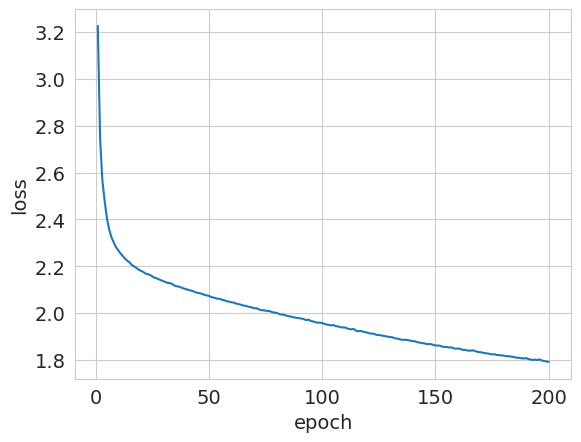

In [59]:
losses = []
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) - need to transpose logits
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]
    
    losses += [running_loss / len(dataset)]
    
    if epoch % 10 == 0:
        plot_losses(losses)

In [60]:
# unconditional generation
[model.inference('') for _ in range(10)]

['luard',
 'solonta',
 'anarile',
 'sandrasta',
 'tiltargas',
 'kvenelne',
 'philaern',
 'martaeril',
 'ilchoril',
 'welenar']

In [61]:
# conditional generation from prefix
[model.inference('an') for _ in range(10)]

['anmikliastra',
 'antarf',
 'analarym',
 'annestir',
 'angar',
 'anaramlar',
 'anautheril',
 'antarro',
 'anajgara',
 'anathwyl']

# 2. Image captioning

In [ ]:
%%bash
kaggle datasets download -d adityajn105/flickr8k
unzip flickr8k.zip

In [62]:
import os
import pandas as pd
from PIL import Image

In [63]:
captions = pd.read_csv('../datasets/flickr/captions.txt', sep=',').dropna()
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


1: A black dog and a spotted dog are fighting
2: A black dog and a tri-colored dog playing with each other on the road .
3: A black dog and a white dog with brown spots are staring at each other in the street .
4: Two dogs of different breeds looking at each other on the road .
5: Two dogs on pavement moving toward each other .


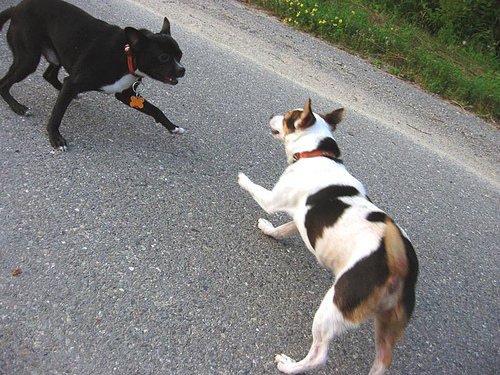

In [64]:
image_file = captions.image.sample(1).iloc[0]

for i, caption in enumerate(captions[captions.image == image_file].caption):
    print(f'{i + 1}:', caption)

Image.open(os.path.join('../datasets/flickr/Images', image_file))

In [65]:
image_ids = {k: i for i, k in enumerate(captions.image.unique())}
image_list = list(map(lambda x: x[0], sorted(image_ids.items(), key=lambda x: x[1])))
captions['image_id'] = captions.image.map(image_ids)

In [66]:
class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        image_path = os.path.join(self.root, self.image_list[item])
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

In [67]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)
cnn_model.classifier = nn.Identity()

cnn_model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 21.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [68]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='../datasets/flickr/Images/', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=4, shuffle=False, batch_size=128)

In [69]:
image_embeds = []

with torch.no_grad():
    for images in tqdm(dataloader):
        embeds = cnn_model(images.to(device))
        image_embeds += [embeds.cpu()]

image_embeds = torch.cat(image_embeds, dim=0)

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

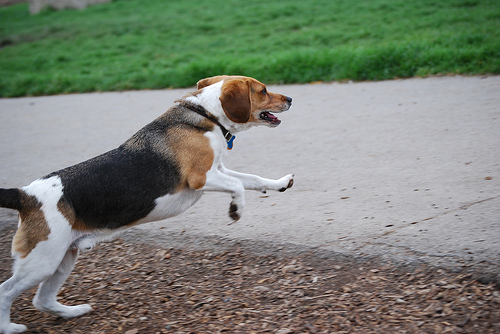

In [70]:
i = 1001

image = Image.open(f'../datasets/flickr/Images/{image_list[i]}').convert('RGB')
image

In [71]:
captions[captions.image_id == 1001]

,image,caption,image_id
5005,2099323664_bb20457f26.jpg,a dog jumps onto the sidewalk .,1001
5006,2099323664_bb20457f26.jpg,A small dog runs from the dirt onto the street,1001
5007,2099323664_bb20457f26.jpg,"A tan , white , and black dog runs towards a s...",1001
5008,2099323664_bb20457f26.jpg,Dog leaps out .,1001
5009,2099323664_bb20457f26.jpg,The brown and white dog is standing on its hin...,1001


In [72]:
image_embeds[i]

tensor([0.4849, 0.3162, 1.1231,  ..., 0.8350, 0.0597, 0.8875])

In [73]:
with torch.no_grad():
    print(cnn_model(transform(image).to(device).unsqueeze(0)))

tensor([[0.4862, 0.3163, 1.1233,  ..., 0.8332, 0.0602, 0.8873]],
       device='cuda:0')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [74]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_embeds, test_embeds = \
    train_test_split(image_list, image_embeds, test_size=0.25, random_state=42)

train_embeds.shape, test_embeds.shape

(torch.Size([6068, 1280]), torch.Size([2023, 1280]))

In [75]:
train_captions = captions[captions.image.isin(train_images)]
test_captions = captions[captions.image.isin(test_images)]

train_captions.shape, test_captions.shape

((30340, 3), (10115, 3))

In [76]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english", language="en")
train_captions['tokens'] = train_captions.caption.apply(tokenizer)
test_captions['tokens'] = test_captions.caption.apply(tokenizer)

specials = ['<pad>', '<bos>', '<eos>', '<unk>']
vocab = build_vocab_from_iterator(train_captions.tokens, specials=specials, min_freq=5)
itos = vocab.get_itos()

PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX = vocab['<pad>'], vocab['<bos>'], vocab['<eos>'], vocab['<unk>']
vocab.set_default_index(UNK_IDX)
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

/tmp/ipykernel_44/64721723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_captions['tokens'] = train_captions.caption.apply(tokenizer)
/tmp/ipykernel_44/64721723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_captions['tokens'] = test_captions.caption.apply(tokenizer)


2580

Train max length: 38


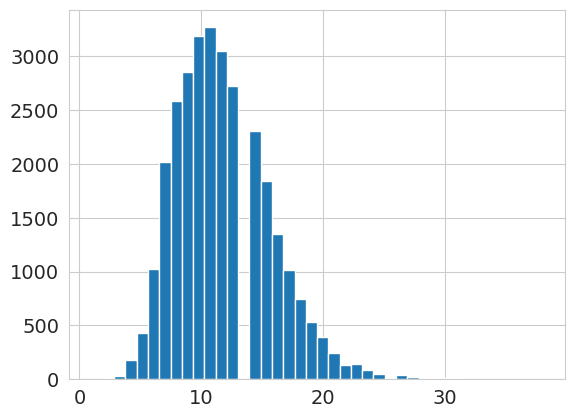

In [80]:
print('Train max length:', train_captions.tokens.apply(len).max())
plt.hist(train_captions.tokens.apply(len), bins=40)
MAX_LENGTH = 30
plt.show()

In [81]:
train_captions

,image,caption,image_id,tokens
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,1,"[a, black, dog, and, a, spotted, dog, are, fig..."
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,1,"[a, black, dog, and, a, tri-colored, dog, play..."
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...,1,"[a, black, dog, and, a, white, dog, with, brow..."
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...,1,"[two, dogs, of, different, breeds, looking, at..."
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,1,"[two, dogs, on, pavement, moving, toward, each..."
...,...,...,...,...
40440,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...,8088,"[a, grey, bird, stands, majestically, on, a, b..."
40441,99679241_adc853a5c0.jpg,A large bird stands in the water on the beach .,8088,"[a, large, bird, stands, in, the, water, on, t..."
40442,99679241_adc853a5c0.jpg,A tall bird is standing on the sand beside the...,8088,"[a, tall, bird, is, standing, on, the, sand, b..."
40443,99679241_adc853a5c0.jpg,A water bird standing at the ocean 's edge .,8088,"[a, water, bird, standing, at, the, ocean, ', ..."


In [82]:
class CaptionsDataset(Dataset):
    def __init__(self, tokens, embeds):
        super().__init__()
        self.tokens = tokens
        self.embeds = embeds

    def __len__(self):
        return len(self.tokens)

    def tokens_to_idx(self, tokens):
        return [vocab[token] for token in tokens]
    
    def idx_to_tokens(self, idx):
        return [itos[index] for index in idx]

    def encode(self, tokens):
        tokens = ['<bos>'] + tokens + ['<eos>']
        return self.tokens_to_idx(tokens)

    def decode(self, idx):
        tokens = self.idx_to_tokens(idx)
        return ' '.join(token for token in tokens if token not in specials)

    def __getitem__(self, item):
        tokens = self.tokens.iloc[item].tokens
        encoded = self.encode(tokens)[:MAX_LENGTH + 2]
        padded = torch.full((MAX_LENGTH + 2, ), PAD_IDX, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)

        image_id = self.tokens.iloc[item].image_id
        return padded, len(encoded), self.embeds[image_id]

In [83]:
train_set = CaptionsDataset(train_captions, image_embeds)
test_set = CaptionsDataset(test_captions, image_embeds)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
# embeds_loader = DataLoader(test_embeds, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [84]:
captions_list = []

for image in tqdm(test_images):
    data = test_captions[test_captions.image == image]
    captions_list += [data.caption.str.lower().tolist()]

  0%|          | 0/2023 [00:00<?, ?it/s]

In [86]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


class CaptionRNN(nn.Module):
    def __init__(self, image_embed_dim, embed_dim=256, hidden_dim=256, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.cnn = MobileNet()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.image_embed_to_h0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )

        self.embedding = nn.Embedding(
            num_embeddings=VOCAB_SIZE,
            embedding_dim=embed_dim,
            padding_idx=PAD_IDX
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )

        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, VOCAB_SIZE)
        )

    def forward(self, tokens, lengths, image):
        '''
        B - batch size
        M - lstm layers
        L - sequence length
        I - image embedding dim
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        image_embed = self.cnn(image)
        
        # image_embeds: (B, I)
        B = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        # h0, co: (M, B, H)

        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form

        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, (h, c) = self.lstm(packed_embeds, (h0, c0))
        # output: (B, L, H) in packed form, (h, c): (M, B, H)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        # generate lstm input
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        h, c = h.contiguous(), c.contiguous()

        # init tokens with <bos>
        tokens = torch.full((B, 1), BOS_IDX, device=image_embeds.device)
        new_tokens = tokens

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < MAX_LENGTH:
            if ((tokens == EOS_IDX).sum(1) > 0).all():
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output)

            # get new tokens from logits
            new_tokens = logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens

In [88]:
# testing
model = CaptionRNN(image_embeds.shape[1], lstm_layers=3)

for tokens, lengths, embeds in train_loader:
    break

tokens = tokens[:, :lengths.max()]
logits = model(tokens, lengths, embeds)
assert logits.shape == (tokens.shape[0], tokens.shape[1], VOCAB_SIZE)

tokens = model.inference(embeds)
train_set.decode(tokens[0])

'coffee carts arm carts golf golf golf golf golf seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull seagull'

In [89]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np


BLEU_FREQ = 5


def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [97]:
from torchmetrics import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for tokens, lengths, embeds in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        optimizer.zero_grad()
        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for tokens, lengths, embeds in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])

        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, embeds_loader, captions):
    bleu = BLEUScore()
    predictions = []
    model.eval()
    for _, _, embeds in tqdm(embeds_loader, desc='Evaluating BLEU'):
        tokens = model.inference(embeds.to(device)).cpu()
        for token_list in tokens:
            predictions += [train_set.decode(token_list)]
    
    return bleu(predictions, captions).item()


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, captions_list, num_epochs):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % BLEU_FREQ == 0:
            valid_bleu = evaluate_bleu(model, test_loader, captions_list)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [98]:
NUM_EPOCHS = 20

model = CaptionRNN(image_embeds.shape[1], dropout=0.3).to(device)
optimizer = torch.optim.Adam(
    {
        "params": model.rnn.params, "lr": 1e-3, weight_decay=1e-6}
    {
        "params": model.cnn.params, "lr": 1e-4,
)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

sum(param.numel() for param in model.parameters())

2505748

In [99]:
print(f'Random BLEU: {evaluate_bleu(model, test_loader, captions_list):.4f}')

Evaluating BLEU:   0%|          | 0/80 [00:00<?, ?it/s]

Random BLEU: 0.0000


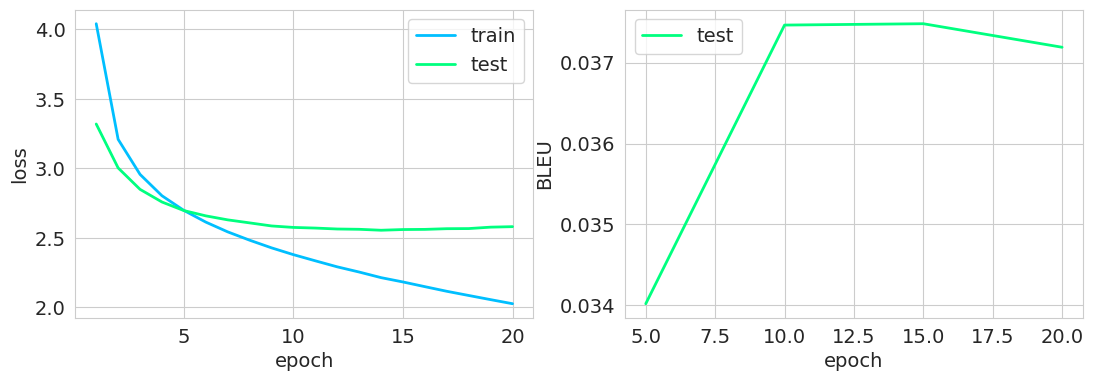

In [100]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, captions_list, NUM_EPOCHS)

In [101]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(image_embeds[index].unsqueeze(0).to(device)).cpu().squeeze()
    prediction = train_set.decode(tokens)
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions.image == image_file].caption):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(os.path.join('../datasets/flickr/Images/', image_file)).convert('RGB')

Prediction: a brown dog is playing with a brown dog in a grassy field .
GT caption #1: A person snowboarding down a snowy hill .
GT caption #2: A snowboarder is coming down a hill .
GT caption #3: Person snowboarding down a snow covered slope .
GT caption #4: Someone is snowboarding down a hill , shredding snow .
GT caption #5: The man is snowboarding down a snowy hill .


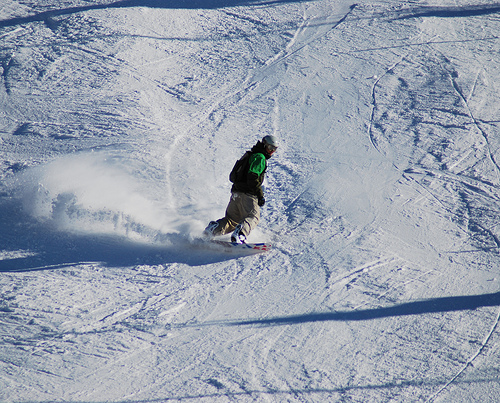

In [108]:
caption_random_test_image()

# 3. Code reproducibility

In [109]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [117]:
set_random_seed(0xDEADF00D)

In [118]:
a = nn.Conv2d(1, 1, kernel_size=3, bias=True).to(device)
a.weight, a.bias

(Parameter containing:
 tensor([[[[-0.2808, -0.1553,  0.2176],
           [ 0.1008,  0.0012, -0.1642],
           [-0.0923, -0.2754,  0.3187]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2705], device='cuda:0', requires_grad=True))

In [112]:
x = torch.randn(1, 1, 5, 5).to(device)
x

tensor([[[[-0.4343,  1.8815,  0.1638,  1.3481, -0.4343],
          [ 0.1004, -0.4767, -0.0350,  2.4472,  2.7177],
          [ 2.8190, -0.1433, -0.3422, -0.1957,  0.0862],
          [-1.5015,  1.1933,  0.6985, -0.4518,  0.6744],
          [-1.0870, -1.9972,  0.7447,  0.6049,  2.6260]]]], device='cuda:0')

In [113]:
a(x)

tensor([[[[-0.1785, -0.3950, -0.4133],
          [ 0.6813,  0.5130,  0.7175],
          [ 0.0497,  0.6885,  0.9763]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)

In [114]:
dataloader = DataLoader(torch.arange(20), shuffle=True, num_workers=4, batch_size=3)
for batch in dataloader:
    print(batch)

tensor([5, 4, 8])
tensor([17,  7,  0])
tensor([ 1, 10, 15])
tensor([ 6,  3, 12])
tensor([ 2, 11, 14])
tensor([18, 13, 16])
tensor([ 9, 19])


In [119]:
set_random_seed(0xDEADF00D)

In [120]:
a = nn.Conv2d(1, 1, kernel_size=3, bias=True).to(device)
a.weight, a.bias

(Parameter containing:
 tensor([[[[-0.2808, -0.1553,  0.2176],
           [ 0.1008,  0.0012, -0.1642],
           [-0.0923, -0.2754,  0.3187]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2705], device='cuda:0', requires_grad=True))

In [121]:
x = torch.randn(1, 1, 5, 5).to(device)
x

tensor([[[[-0.4343,  1.8815,  0.1638,  1.3481, -0.4343],
          [ 0.1004, -0.4767, -0.0350,  2.4472,  2.7177],
          [ 2.8190, -0.1433, -0.3422, -0.1957,  0.0862],
          [-1.5015,  1.1933,  0.6985, -0.4518,  0.6744],
          [-1.0870, -1.9972,  0.7447,  0.6049,  2.6260]]]], device='cuda:0')

In [122]:
a(x)

tensor([[[[-0.1785, -0.3950, -0.4133],
          [ 0.6813,  0.5130,  0.7175],
          [ 0.0497,  0.6885,  0.9763]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)

In [123]:
dataloader = DataLoader(torch.arange(20), shuffle=True, num_workers=4, batch_size=3)
for batch in dataloader:
    print(batch)

tensor([5, 4, 8])
tensor([17,  7,  0])
tensor([ 1, 10, 15])
tensor([ 6,  3, 12])
tensor([ 2, 11, 14])
tensor([18, 13, 16])
tensor([ 9, 19])


In [ ]:
def main():
    set_seed()

    model = Model()

    dataloader = DataLoader()

    for epoch in num_epoches:
        train()